# OLA3
### Gruppe H (Caroline og Maria)

In [1]:
import os, cv2

import tensorflow as tf
import keras

import numpy as np
import pandas as pd
import random
from random import shuffle

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam

In [2]:
# TF Version
tf.__version__

'2.16.1'

### Quick data exploration
We wanted to see what kind of images are in the data sets, so we just showed a single image from the test folder. This was also done just to ensure that the data we were shown matched what we could see in the folder.

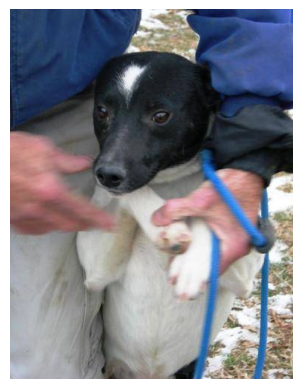

In [3]:
image_path = "Data/CNN/test/1.jpg"
image = Image.open(image_path)

plt.imshow(image)
plt.axis('off')
plt.show()

## Data Ingestion
To start with, we ingested the data from the two image folders.

In [4]:
train_dir = './Data/CNN/train'
test_dir = './Data/CNN/test'

In [5]:
train_img_list = os.listdir(train_dir)
test_img_list = os.listdir(test_dir)

We chose to randomly shuffle the data to avoid introducing bias in our model later, since the data was structured with first just cat images, then just dog images.

In [6]:
shuffle(train_img_list)
shuffle(test_img_list)

Then we checked to see, how much data was in each folder.

In [7]:
print('Train size: %d. Test size: %d' % (len(train_img_list), len(test_img_list)))

Train size: 5533. Test size: 12500


### Splitting into train, val, and test set
We created a function called `load_images_and_labels` to split the images from the train and test folder into images, for `x` and labels for `y`. However, there are no labels in the test folder, so we created a boolean to see whether the data is train data or not. We also chose to make a default value for the img_size that we will use, but can change if we want to later.

We also encoded the labels using Label Encoder from SciKit Learn.

In [8]:
def load_images_and_labels(dir, img_list, isTrainData, img_size=(224,224)):
    images = []
    labels = []

    if isTrainData:
        label_encoder = LabelEncoder()
        label_names = [filename.split('.')[0] for filename in img_list]
        labels = label_encoder.fit_transform(label_names)
        label_mapping = dict(zip(label_encoder.classes_, 
                                 label_encoder.transform(label_encoder.classes_)))
        print(label_mapping)
    
    for filename in tqdm(img_list):
        img_og = cv2.imread(os.path.join(dir, filename))
        img_resize = cv2.resize(img_og, img_size) 
        img_norm = img_resize / 255.0 # to resize and normalize 
        images.append(img_norm)
    return np.array(images), np.array(labels)

In [9]:
x_train, y_train = load_images_and_labels(train_dir, train_img_list, True)

{'cat': 0, 'dog': 1}


100%|██████████| 5533/5533 [00:17<00:00, 314.34it/s]


We then split our train set into a train and validation set, with 80 % of the data used for training and 20 % for validation. We used stratified splitting to ensure that both strata, cats and dogs, are equally represented in the sample.

In [10]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, 
                                                  stratify=y_train, random_state=42)

We then save the data, so we can access the same data later.

In [11]:
np.savez('./Data/Saved_data/train_and_val_data.npz', 
         x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val)

And here we get the test data, and as mentioned before, there are no labels, so `y_test` is actually empty.

In [12]:
x_test, y_test = load_images_and_labels(test_dir, test_img_list, False)

100%|██████████| 12500/12500 [00:52<00:00, 238.69it/s]


In [13]:
y_test

array([], dtype=float64)

We save `x_test` to access later as well, not `y_test`, since test has no labels.

In [14]:
np.savez('./Data/Saved_data/test_data.npz', x_test=x_test)

### Data Exploration
Here, we explore the data more, and make sure there are no missing values. 

First, we load our saved data.

In [8]:
train_and_val_data = np.load('./Data/Saved_data/train_and_val_data.npz')
x_train = train_and_val_data['x_train']
y_train = train_and_val_data['y_train']
x_val = train_and_val_data['x_val']
y_val = train_and_val_data['y_val']

In [56]:
test_data = np.load('./Data/Saved_data/test_data.npz')
x_test = test_data['x_test']

In [17]:
print('Train size: %d. Validation size: %d' % (len(x_train), len(x_val)))

Train size: 4426. Validation size: 1107


We chose to look at `x_train` for image on index 10 to see what kind of data we have now.

In [18]:
x_train[10]

array([[[0.51372549, 0.85098039, 0.73333333],
        [0.69803922, 0.87843137, 0.78431373],
        [0.75686275, 0.76862745, 0.70980392],
        ...,
        [0.45882353, 0.62352941, 0.53333333],
        [0.62745098, 0.70588235, 0.65490196],
        [0.78823529, 0.83529412, 0.79607843]],

       [[0.41176471, 0.7254902 , 0.61568627],
        [0.58431373, 0.75294118, 0.6627451 ],
        [0.85882353, 0.87843137, 0.81960784],
        ...,
        [0.71764706, 0.85098039, 0.76470588],
        [0.48235294, 0.64313725, 0.56862745],
        [0.34509804, 0.50980392, 0.44313725]],

       [[0.49803922, 0.77254902, 0.6627451 ],
        [0.63529412, 0.79607843, 0.70588235],
        [0.86666667, 0.90980392, 0.85098039],
        ...,
        [0.5254902 , 0.63137255, 0.55294118],
        [0.51764706, 0.69019608, 0.61568627],
        [0.45490196, 0.64313725, 0.57647059]],

       ...,

       [[0.49019608, 0.57254902, 0.59215686],
        [0.38039216, 0.46666667, 0.48235294],
        [0.5372549 , 0

In [19]:
x_train[10].shape

(224, 224, 3)

In [20]:
y_train[10]

1

In [21]:
x_train.shape

(4426, 224, 224, 3)

In [22]:
y_train.shape

(4426,)

#### Checking for missing data

In [23]:
np.isnan(x_train).sum()

0

In [24]:
np.isnan(x_test).sum()

0

In [25]:
np.isnan(x_val).sum()

0

### Visualize Data
Now we will visuliaze some of the train data. To see the labels as text, we created a function that can decode the Label encoding we made earlier and we know that `{'cat': 0, 'dog': 1}`.

In [26]:
def get_label_from_encoding(enc_label):
    return 'cat' if enc_label == 0 else 'dog'

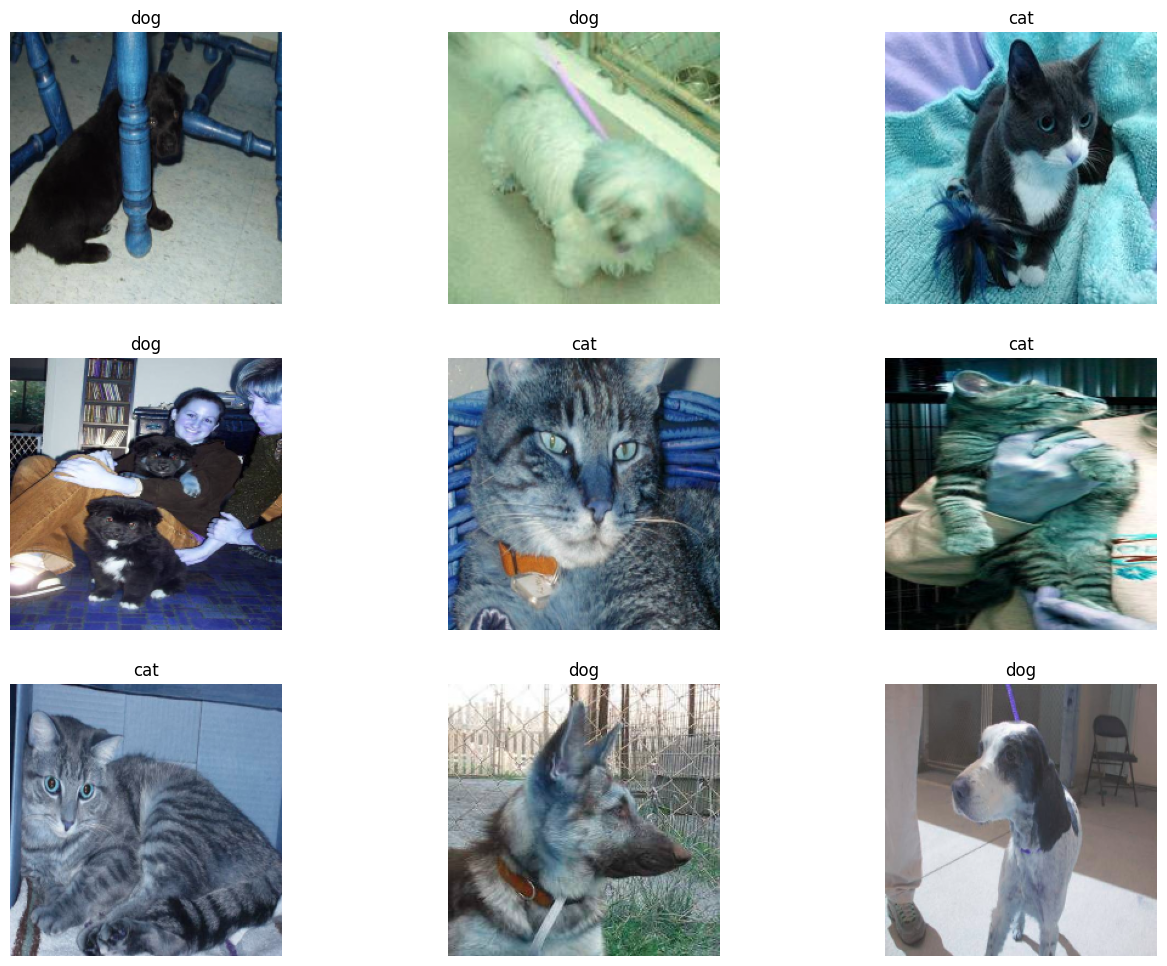

In [27]:
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for idx, ax in enumerate(axes.ravel()):
    img = x_train[idx]
    ax.set_title(get_label_from_encoding(y_train[idx]))
    ax.imshow(img)
    ax.axis('off')

## ANN
We tried to create a ANN model, but we couldn't get the `flow_from_directory` function to find any pictures. 

In [35]:
train_datagen = ImageDataGenerator(rescale=1/255.0)

In [36]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    #'./Data/CNN/train',
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    #test_dir,
    './Data/CNN/test',
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.


In [74]:
train_dataset = keras.utils.image_dataset_from_directory(
    directory = train_dir,
    labels = "inferred",
    label_mode = "int",
    batch_size = 32,
    image_size = (128, 128)
)

validation_dataset = keras.utils.image_dataset_from_directory(
    directory = test_dir,
    labels = "inferred",
    label_mode = "int",
    batch_size = 32,
    image_size = (128, 128)
)

Found 0 files belonging to 0 classes.


ValueError: No images found in directory ./Data/CNN/train. Allowed formats: ('.bmp', '.gif', '.jpeg', '.jpg', '.png')

In [24]:
ann_model = Sequential([
    Flatten(input_shape=(150, 150, 3)),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

C:\Users\Caroline\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [26]:
ann_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 67500)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     8,640,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,640,257 (32.96 MB)

 Trainable params: 8,640,257 (32.96 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
ann_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [44]:
ann_history = ann_model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=50
)

ValueError: Must provide at least one structure

## CNN

In [41]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3), padding='valid', activation='relu',
                 input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

model.add(Conv2D(64, kernel_size=(3,3), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

model.add(Conv2D(128, kernel_size=(3,3), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [42]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,177,281 (42.64 MB)

 Trainable params: 11,177,281 (42.64 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy', metrics=['accuracy'])

When fitting the model, we actually split the training set once again into train and validation. This time only 10 % will be used for validation.

In [44]:
history = model.fit(x_train, y_train, epochs=10, 
                    validation_split=0.1)

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 56s 422ms/step - accuracy: 0.5028 - loss: 0.7815 - val_accuracy: 0.6117 - val_loss: 0.6644
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 52s 418ms/step - accuracy: 0.6087 - loss: 0.6603 - val_accuracy: 0.6050 - val_loss: 0.6686
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 59s 469ms/step - accuracy: 0.6433 - loss: 0.6308 - val_accuracy: 0.6456 - val_loss: 0.6257
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 59s 475ms/step - accuracy: 0.6866 - loss: 0.5827 - val_accuracy: 0.6727 - val_loss: 0.6293
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 60s 482ms/step - accuracy: 0.7604 - loss: 0.4832 - val_accuracy: 0.7043 - val_loss: 0.6239
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 60s 476ms/step - accuracy: 0.8455 - loss: 0.3458 - val_accuracy: 0.7065 - val_loss: 0.7853
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 59s 475ms/step - accuracy: 0.9199 - loss: 0.2028 - val_accuracy: 0.7314 - val_loss: 1.0505
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 60s 481ms/step - accuracy: 0.9665 - loss: 0

### Accuracy Estimation

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

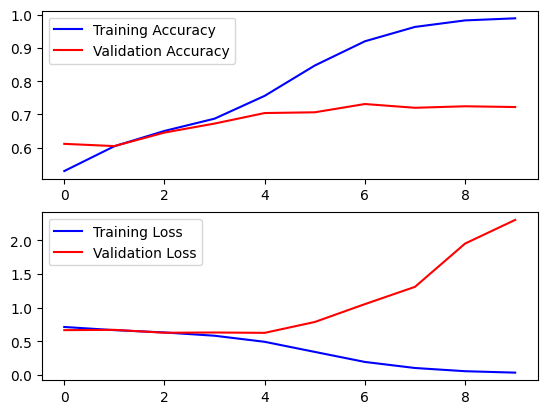

In [46]:
fig, ax = plt.subplots(2,1)

ax[0].plot(acc, color='b', label="Training Accuracy")
ax[0].plot(val_acc, color='r', label="Validation Accuracy")
legend = ax[0].legend(loc='best')

ax[1].plot(loss, color='b', label="Training Loss")
ax[1].plot(val_loss, color='r', label="Validation Loss")
legend = ax[1].legend(loc='best')

### With Validation Data
Then we tested our model with our validation data to test it with labelled data again.

In [47]:
val_loss, val_acc = model.evaluate(x_val, y_val)
val_loss

35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - accuracy: 0.7141 - loss: 1.8859


1.993478775024414

In [48]:
val_acc

0.7037037014961243

In [49]:
y_val_pred = model.predict(x_val)
y_val_pred_labels = np.round(y_val_pred)

35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step


<Axes: >

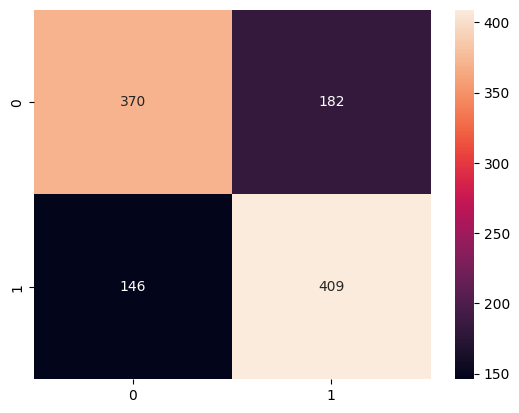

In [50]:
val_conf = tf.math.confusion_matrix(y_val, y_val_pred_labels) 
sns.heatmap(val_conf, annot=True, fmt='g')

The model correctly identified 370 cats as cats (true negative), but wrongly identified 182 dogs as cats (false positive). The model also wrongfully identified 146 cats as dogs (false negative), but rightly identified 409 dogs as dogs (true positive).

#### Manual test of Cat and Dog Image
We will also just manually test a cat image and a dog image that we found on google to see the model's prediction.

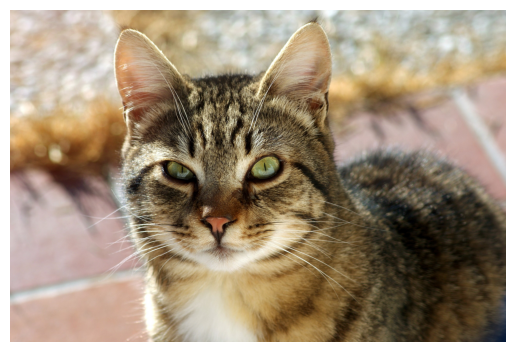

In [48]:
test_cat = Image.open('./Data/Manual_test/cat.jpg')

plt.imshow(test_cat)
plt.axis('off')
plt.show()

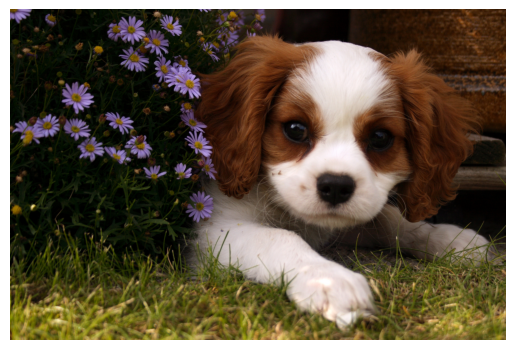

In [49]:
test_dog = Image.open('./Data/Manual_test/dog.jpg')

plt.imshow(test_dog)
plt.axis('off')
plt.show()

In [53]:
small_test_dir = './Data/Manual_test'
small_test_img_list = os.listdir(small_test_dir)

x_small_test, y_small_test = load_images_and_labels(small_test_dir, 
                                                    small_test_img_list, True)

{'cat': 0, 'dog': 1}


100%|██████████| 2/2 [00:00<00:00,  2.89it/s]


In [54]:
y_small_pred = model.predict(x_small_test)
y_small_pred_labels = np.round(y_small_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step


<Axes: >

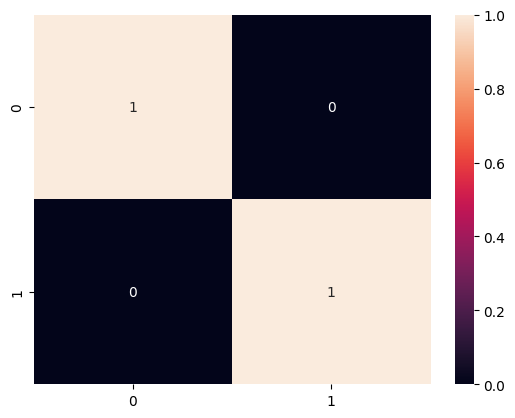

In [55]:
val_conf = tf.math.confusion_matrix(y_small_test, y_small_pred_labels) 
sns.heatmap(val_conf, annot=True, fmt='g')

It correctly identified both pictures as a cat and dog, respectively.

### With Test data
Finally, we tested the model on the unlabelled test dataset.

In [58]:
y_test_pred = model.predict(x_test)
y_test_pred_labels = np.round(y_test_pred)

391/391 ━━━━━━━━━━━━━━━━━━━━ 102s 257ms/step


We chose a small subset of the predictions to plot to see how well the model did predicting.

In [64]:
num_examples = 9
sample_indices = np.random.choice(len(x_test), num_examples, replace=False)
sampled_data = x_test[sample_indices]
sampled_predictions = y_test_pred_labels[sample_indices]

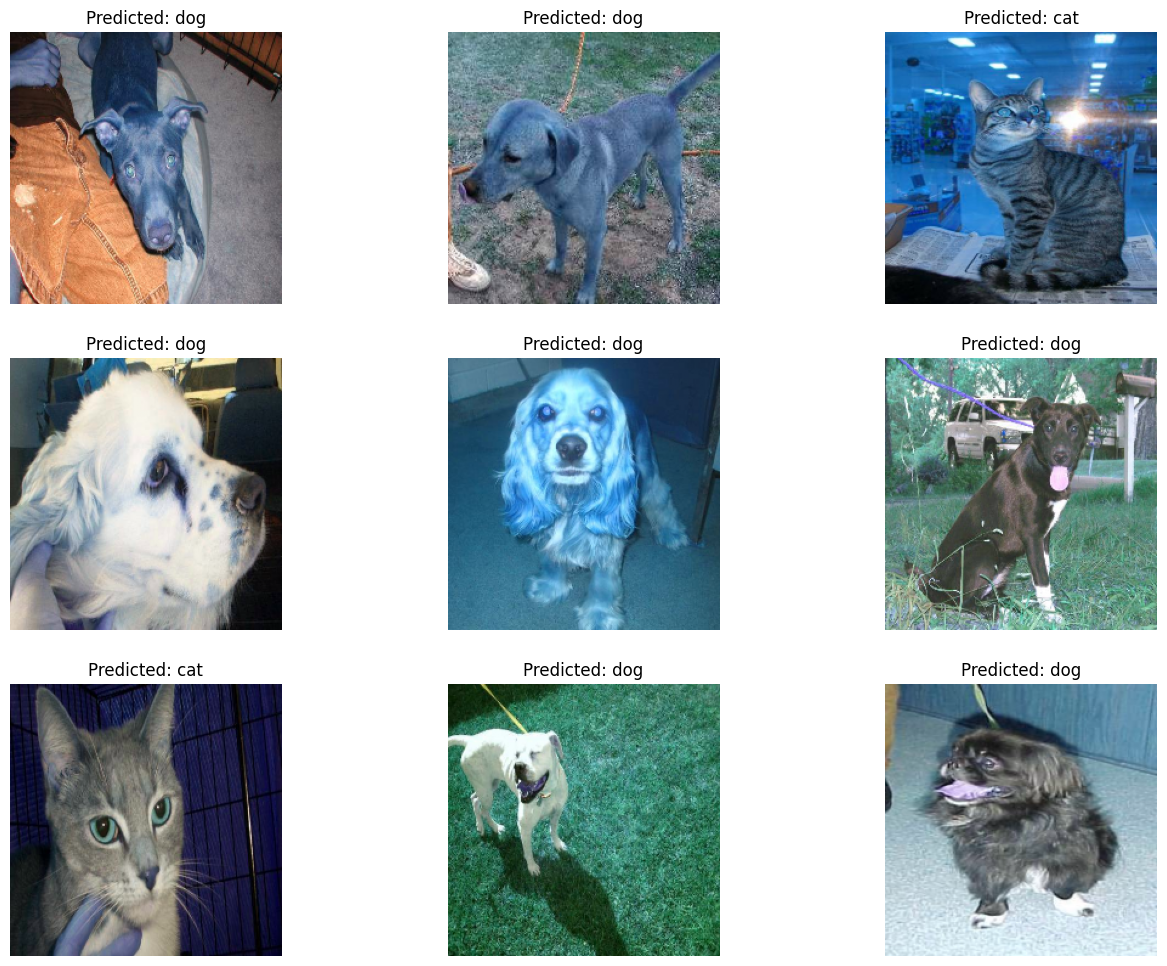

In [66]:
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for idx, ax in enumerate(axes.ravel()):
    img = sampled_data[idx]
    label = get_label_from_encoding(sampled_predictions[idx])
    ax.set_title('Predicted: %s' % (label))
    ax.imshow(img)
    ax.axis('off')

Because of the amount of dogs, we wanted to illustrate 9 more.

In [70]:
more_sample_indices = np.random.choice(len(x_test), num_examples, replace=False)
more_sampled_data = x_test[more_sample_indices]
more_sampled_predictions = y_test_pred_labels[more_sample_indices]

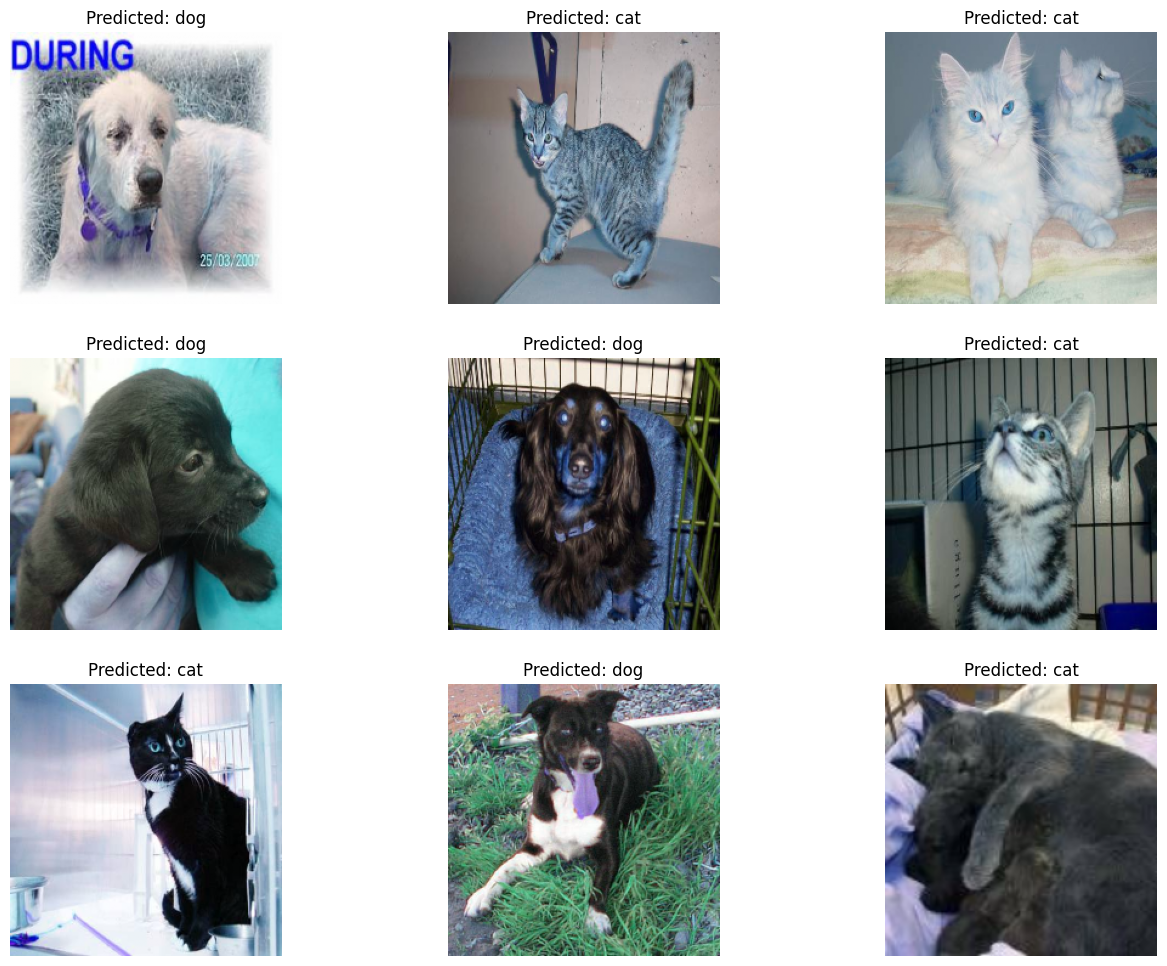

In [71]:
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for idx, ax in enumerate(axes.ravel()):
    img = more_sampled_data[idx]
    label = get_label_from_encoding(more_sampled_predictions[idx])
    ax.set_title('Predicted: %s' % (label))
    ax.imshow(img)
    ax.axis('off')

In [72]:
even_more_sample_indices = np.random.choice(len(x_test), num_examples, replace=False)
even_more_sampled_data = x_test[even_more_sample_indices]
even_more_sampled_predictions = y_test_pred_labels[even_more_sample_indices]

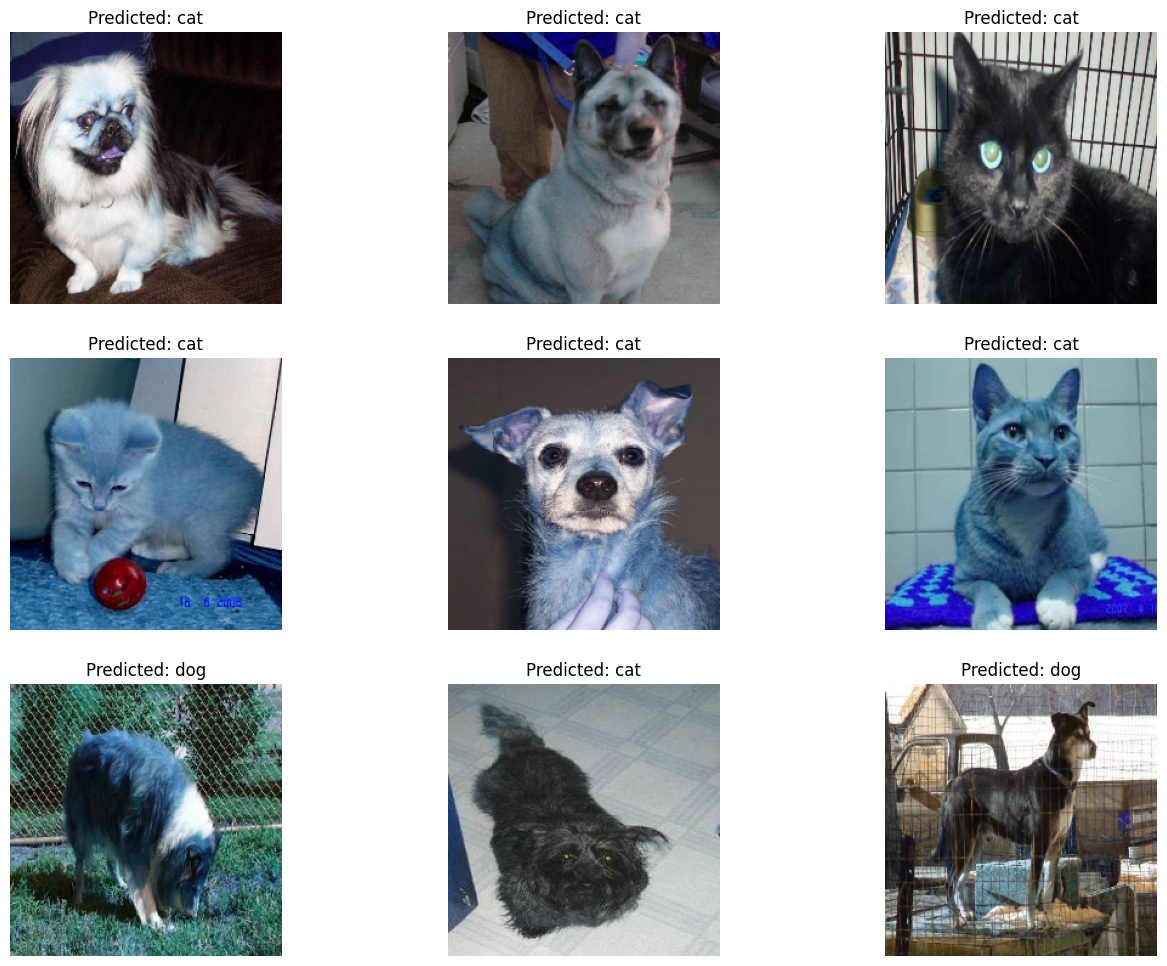

In [73]:
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for idx, ax in enumerate(axes.ravel()):
    img = even_more_sampled_data[idx]
    label = get_label_from_encoding(even_more_sampled_predictions[idx])
    ax.set_title('Predicted: %s' % (label))
    ax.imshow(img)
    ax.axis('off')

We can see that model does wrongly identify some dogs as cats (1st and 2nd picture in 1st row, and 2nd picture in 2nd row, and 2nd in 3rd row). But from our small sample, the model seems to be doing a fine job of correctly identifying whether the image is of a cat or a dog. 

## Save the Model

In [ ]:
from tensorflow.keras.models import save_model

model.save('cat_dog_model.keras')

## Discussing the process

1. Based on your experience, how would you define ANN and CNN?
2. Which hyper-parameters of the CNN architecture have you fine-tuned?
3. Which is the role of the activation functions in ANN? Which of them you have implemented?
Illustrate them
4. Can you see any advantages and disadvantages of ANN and CNN used for classification in
comparison to the other classification algorithms you are familiar with? Give some examples..

### Answer 1
ANN stands for Artifical Neural Network and CNN stands for Convolutional Neural Network.

ANN generally works well in many different tasks. CNN works well in image recognision tasks and is therefore a good fit for this exercise. CNN uses convolutional layers and pooling layers.

In our personal experience, we had some difficulties with creating the ANN model, since we could not figure out how to use the function `flow_from_directory`. We tried other methods as well, but we could not figure out why for example the `image_dataset_from_directory` gave a Value Error saying there where no images, when there is. 

### Answer 2
We changed the hyperparameters for Conv2d, MaxPooling2d, Dense, the activation functions, the padding, the input_shape, the learning rate with Adam, amount of epoch and batch size.

### Answer 3
We tried to use Sigmoid and ReLU. The role is to introduce non-linearity into the network, so the output can be more than a linear sum of the input.

Sigmoid is an S-shaped curve form 0 to 1 (for logistic Sigmoid) and between -1 and 1 (for tanh), and can be useful on the last layer of a binary model, which is how we also used it in our CNN model. It can prevent large or unstable outputs during training. Disadvantages of Sigmoid are that the function is prone to the gradient vanishing problem and that the computation can be computationally expensive when dealing with large datasets. Therefore, we only used it in the last layer.

ReLU stands for rectified linear unit and takes an input x and returns if x is greater than 0 or 0 if not. ReLU can overcome both disadvantages of Sigmoid, since values under zero are discarded, making its computation simpler. 

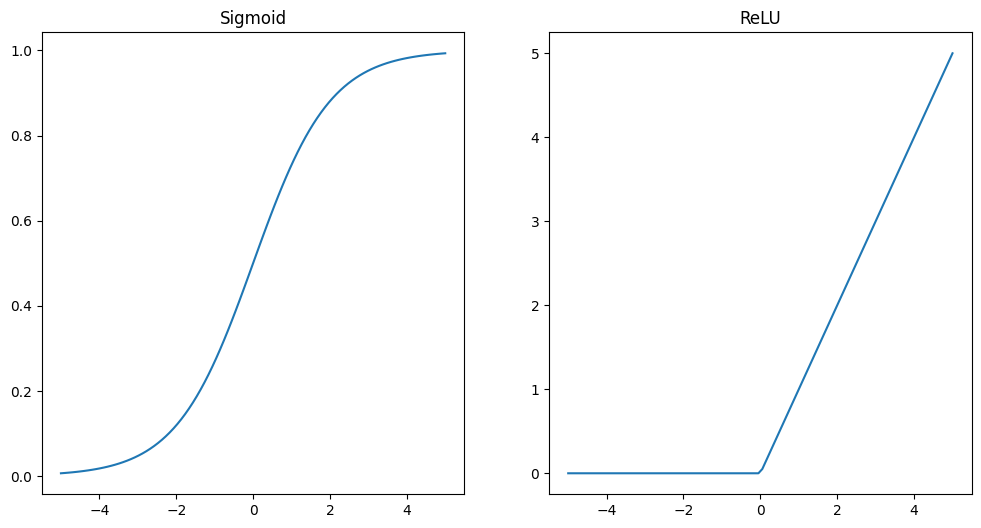

In [79]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(0, x)

x = np.linspace(-5, 5, 100)

sigmoid_output = sigmoid(x)
relu_output = relu(x)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(x, sigmoid_output)
plt.title('Sigmoid')

plt.subplot(1, 2, 2)
plt.plot(x, relu_output)
plt.title('ReLU')
plt.show()

### Answer 4

CNN have been much more computationally expensive for our computers to run than the other classification algorithms.